AIM: To analyze the training dataset.

In [ ]:
# import libraries
from google.colab import drive
import pandas as pd
import os

import spacy
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from matplotlib import pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict, Counter

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# mount google drive and connect working directory
drive.mount('/content/gdrive', force_remount = True)
print (sorted(os.listdir('gdrive/My Drive/Colab Helper/ICData/Dataset')))
os.chdir('gdrive/My Drive/Colab Helper/ICData/Dataset') # Connect to the directory

Mounted at /content/gdrive
['data_file.csv', 'test_.csv', 'train_.csv', 'valid_.csv']


In [ ]:
# read train file and print it's shape
traindf = pd.read_csv('train_.csv', usecols=['text','intent'])
print('Train Shape: ', traindf.shape)

Train Shape:  (9951, 2)


**Observations:**

1.   All the classes have almost equal distribution.



/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Intent Distribution')

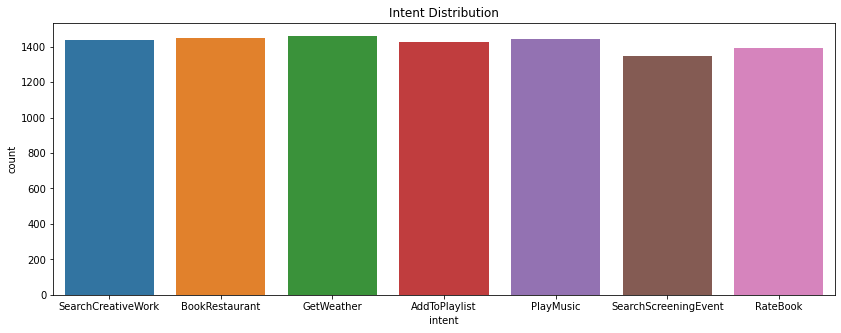

In [ ]:
# plot distribution of class-labels
plt.figure(figsize=(14,5))
sns.countplot(traindf.intent)
plt.title("Intent Distribution")

In [ ]:
# exact count of distribution of class-labels
print('Distribution of class-label (exact count):\n', traindf.intent.value_counts())

Distribution of class-label (exact count):
 GetWeather              1460
BookRestaurant          1447
PlayMusic               1445
SearchCreativeWork      1436
AddToPlaylist           1424
RateBook                1394
SearchScreeningEvent    1345
Name: intent, dtype: int64


**Observations:**

Top 5 words for each intent:

1.   ***PlayMusic***: play, music, song, hear, want
2.   ***RateBook***: rate, give, star, point, current
3.   ***BookRestaurant***: book, restaurant, table, reservation, need
4.   ***GetWeather***: forecast, weather, will, now, s
5.   ***SearchCreativeWork***: find, show, called, tv, game
6.   ***AddToPlaylist***: add, playlist, put, song, tune
7.   ***SearchScreeningEvent***: movie, playing, schedule, theatre, time

Observe that if we use stemmers; then 'play' from PlayMusic and 'playing' from SearchScreeningEvent will result in the same token 'play'. And the number of such tokens that overlap might be higher. Uh Oh!


In [ ]:
# create WordCloud
@widgets.interact(intent=list(set(traindf.intent)))
def display_word_cloud(intent="PlayMusic"):
  plt.figure(figsize=(16, 10))
  subset = traindf[traindf.intent==intent]
  text = subset.text.values
  cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False, max_words=5,
    max_font_size=40, scale=3).generate(" ".join(text))
  plt.axis("off")
  plt.imshow(cloud)

interactive(children=(Dropdown(description='intent', index=1, options=('SearchCreativeWork', 'PlayMusic', 'Boo…

**Observation:**

1.   Length of text ranges from 10 to 125 characters approximately.
2.   More generally they range from 25 to 65 characters approximately.



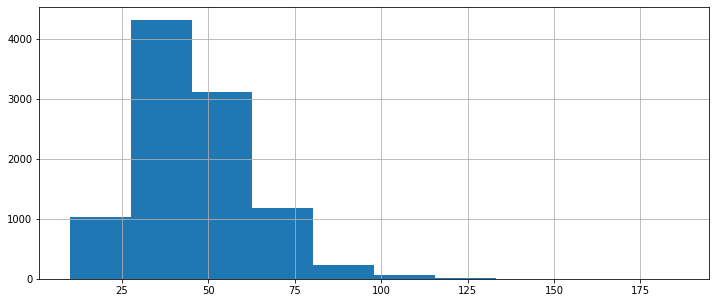

In [ ]:
# plot length of text
fig = plt.figure(figsize = (12,5))
ax = fig.gca()
traindf['text'].str.len().hist(ax=ax)

**Observations:**

1.   Range of words in texts ranges from 2 to 25.
2.   Generally, 6 to 12 words occur in the sentence.



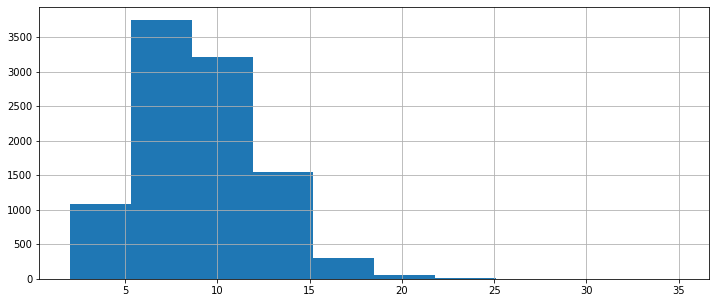

In [ ]:
# plot number of words per sentence
fig = plt.figure(figsize = (12,5))
traindf['text'].str.split().map(lambda x: len(x)).hist()

**Observations:**

1.   'The' is present most among all the stopwords present.
2.   119 stopwords present; this may result in reduced  average length of words.



Total stopwords in texts:  119


<BarContainer object of 20 artists>

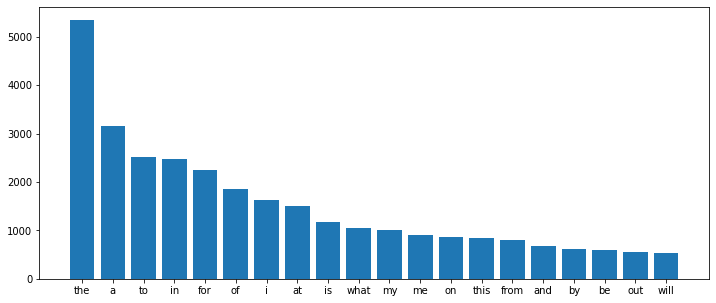

In [ ]:
# plot top 20 stopwords
stop=set(stopwords.words('english'))

# split into words
corpus = []
text = traindf['text'].str.split()
text = text.values.tolist()
corpus = [word for i in text for word in i]

# dictionary with count of each stopword
dic=defaultdict(int)
for word in corpus:
  if word in stop:
    dic[word]+=1
print('Total stopwords in texts: ', len(dic))

# plot top stopwords
top = sorted(dic.items(), key=lambda x:x[1], reverse=True)[:20] # sort the dic and get top 20 stopwords
x, y = zip(*top) # unzip dictionary
plt.figure(figsize=(12,5))
plt.bar(x, y)

**Observations:**

1.   'Play', 'book', and 'add' have appeared the most in texts.
2.   Approximately more than 50 words have high occurance causing skew in plot. These words could be the identifiers of class labels.

Total words to be plotted:  64


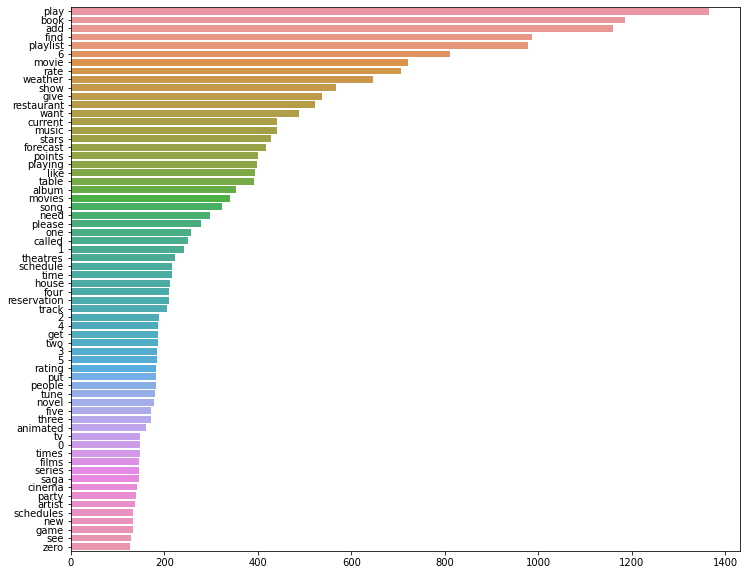

In [ ]:
# plot top words that are not stopwords
counter = Counter(corpus)
most_common = counter.most_common()

# get the most common words that are not stopwords
x, y = [], []
for word, count in most_common[:100]:
  if (word not in stop):
    x.append(word)
    y.append(count)
print('Total words to be plotted: ', len(x))

# plot
plt.figure(figsize=(12,10))
sns.barplot(x=y, y=x)

**NER Tagging**

**Observations:**

1.   Cardinal, i.e., numbers, are present the most.
2.   Data, Person, and GPE ner tags are also present in large quantities. 

In [ ]:
# load pre-trained model for English in spacy
nlp = spacy.load("en_core_web_sm")

# function to get ner tag
def ner(text):
  doc = nlp(text)
  return [X.label_ for X in doc.ents]

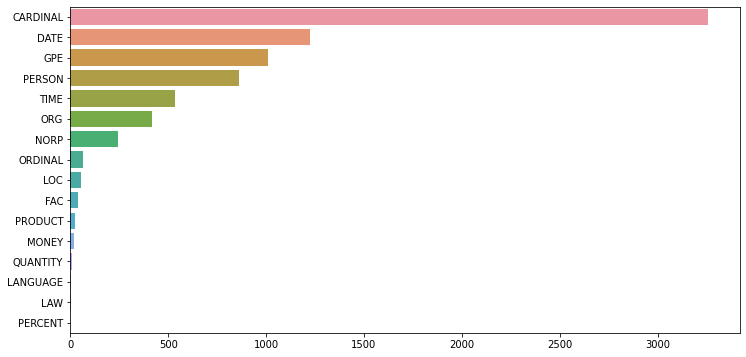

In [ ]:
# ner tag for entire document
per_document_ner_tag_list = traindf['text'].apply(lambda x : ner(x))
tag_list = [tag for ner_tag_list in per_document_ner_tag_list for tag in ner_tag_list]
counter = Counter(tag_list)
count_most_common = counter.most_common()

# plot ner tags
x, y = map(list, zip(*count_most_common))
fig = plt.figure(figsize = (12,6))
sns.barplot(x=y, y=x)

**Observations:**

NER tags dominating per intent:

1.   **PlayMusic**: person, date
2.   **RateBook**: cardinal
3.   **BookRestaurant**: cardinal, gpe
4.   **GetWeather**: gpe, date, time
5.   **SearchCreativeWork**: cardinal, date, person, org, gpe
6.   **AddToPlaylist**: person
7.   **SearchScreeningEvent**: time, cardinal, org

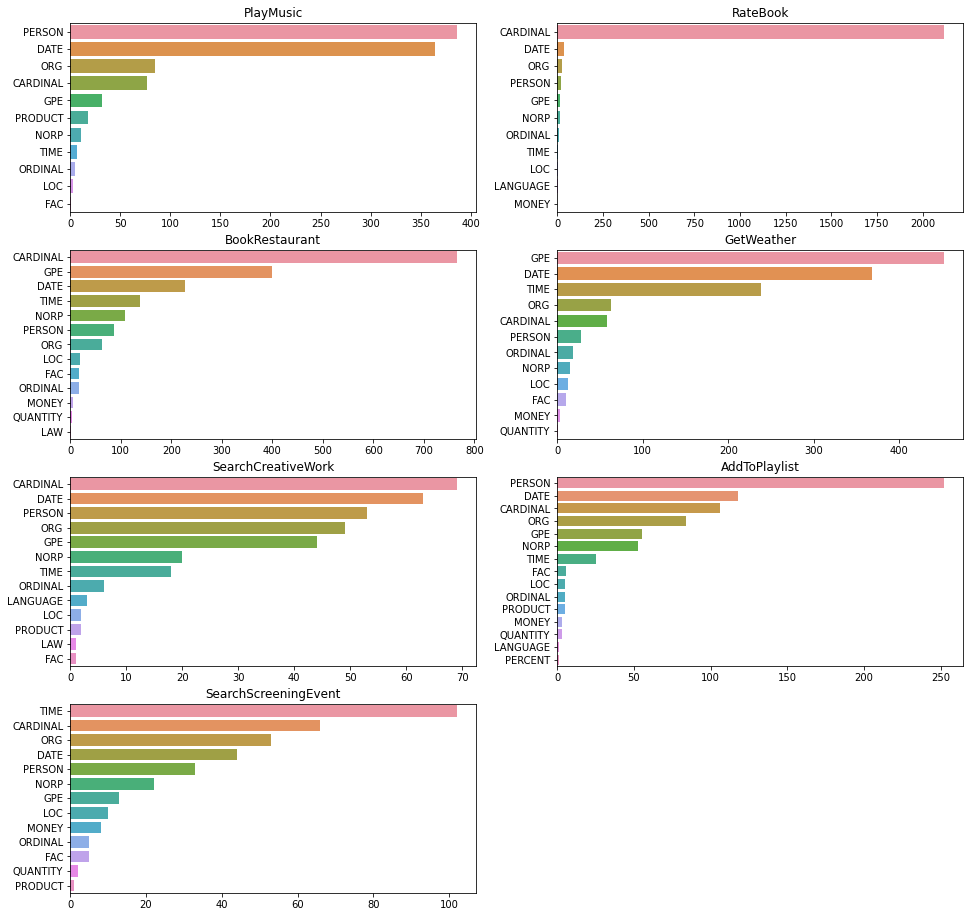

In [ ]:
# ner tag per intent
intent_list = ['PlayMusic', 'RateBook', 'BookRestaurant', 'GetWeather', 'SearchCreativeWork', 'AddToPlaylist', 'SearchScreeningEvent']

plt.figure(figsize=(16, 16))
for i, intent in enumerate(intent_list):
  df = traindf['text'][traindf.intent==intent]
  per_document_ner_tag_list = df.apply(lambda x : ner(x))
  tag_list = [tag for ner_tag_list in per_document_ner_tag_list for tag in ner_tag_list]
  counter = Counter(tag_list)
  count_most_common = counter.most_common()
  # plot ner tags
  x, y = map(list, zip(*count_most_common))
  plt.subplot(4, 2, i+1)
  plt.title('{}'.format(intent))
  sns.barplot(x=y, y=x)

**Conclusion:**

1.   Total rows: 9951; Total columns: 2 (text, intent)
2.   Total 7 classes with almost equal distribution: GetWeather, BookRestaurant, PlayMusic, SearchCreativeWork, AddToPlaylist, RateBook, SearchScreeningEvent.
3.   Length of text ranges from 10 to 125 characters approximately.
4.   Range of words in texts ranges from 2 to 25.
5.   119 stopwords present.
6.   NER tag that was observed most across the documents: cardinal